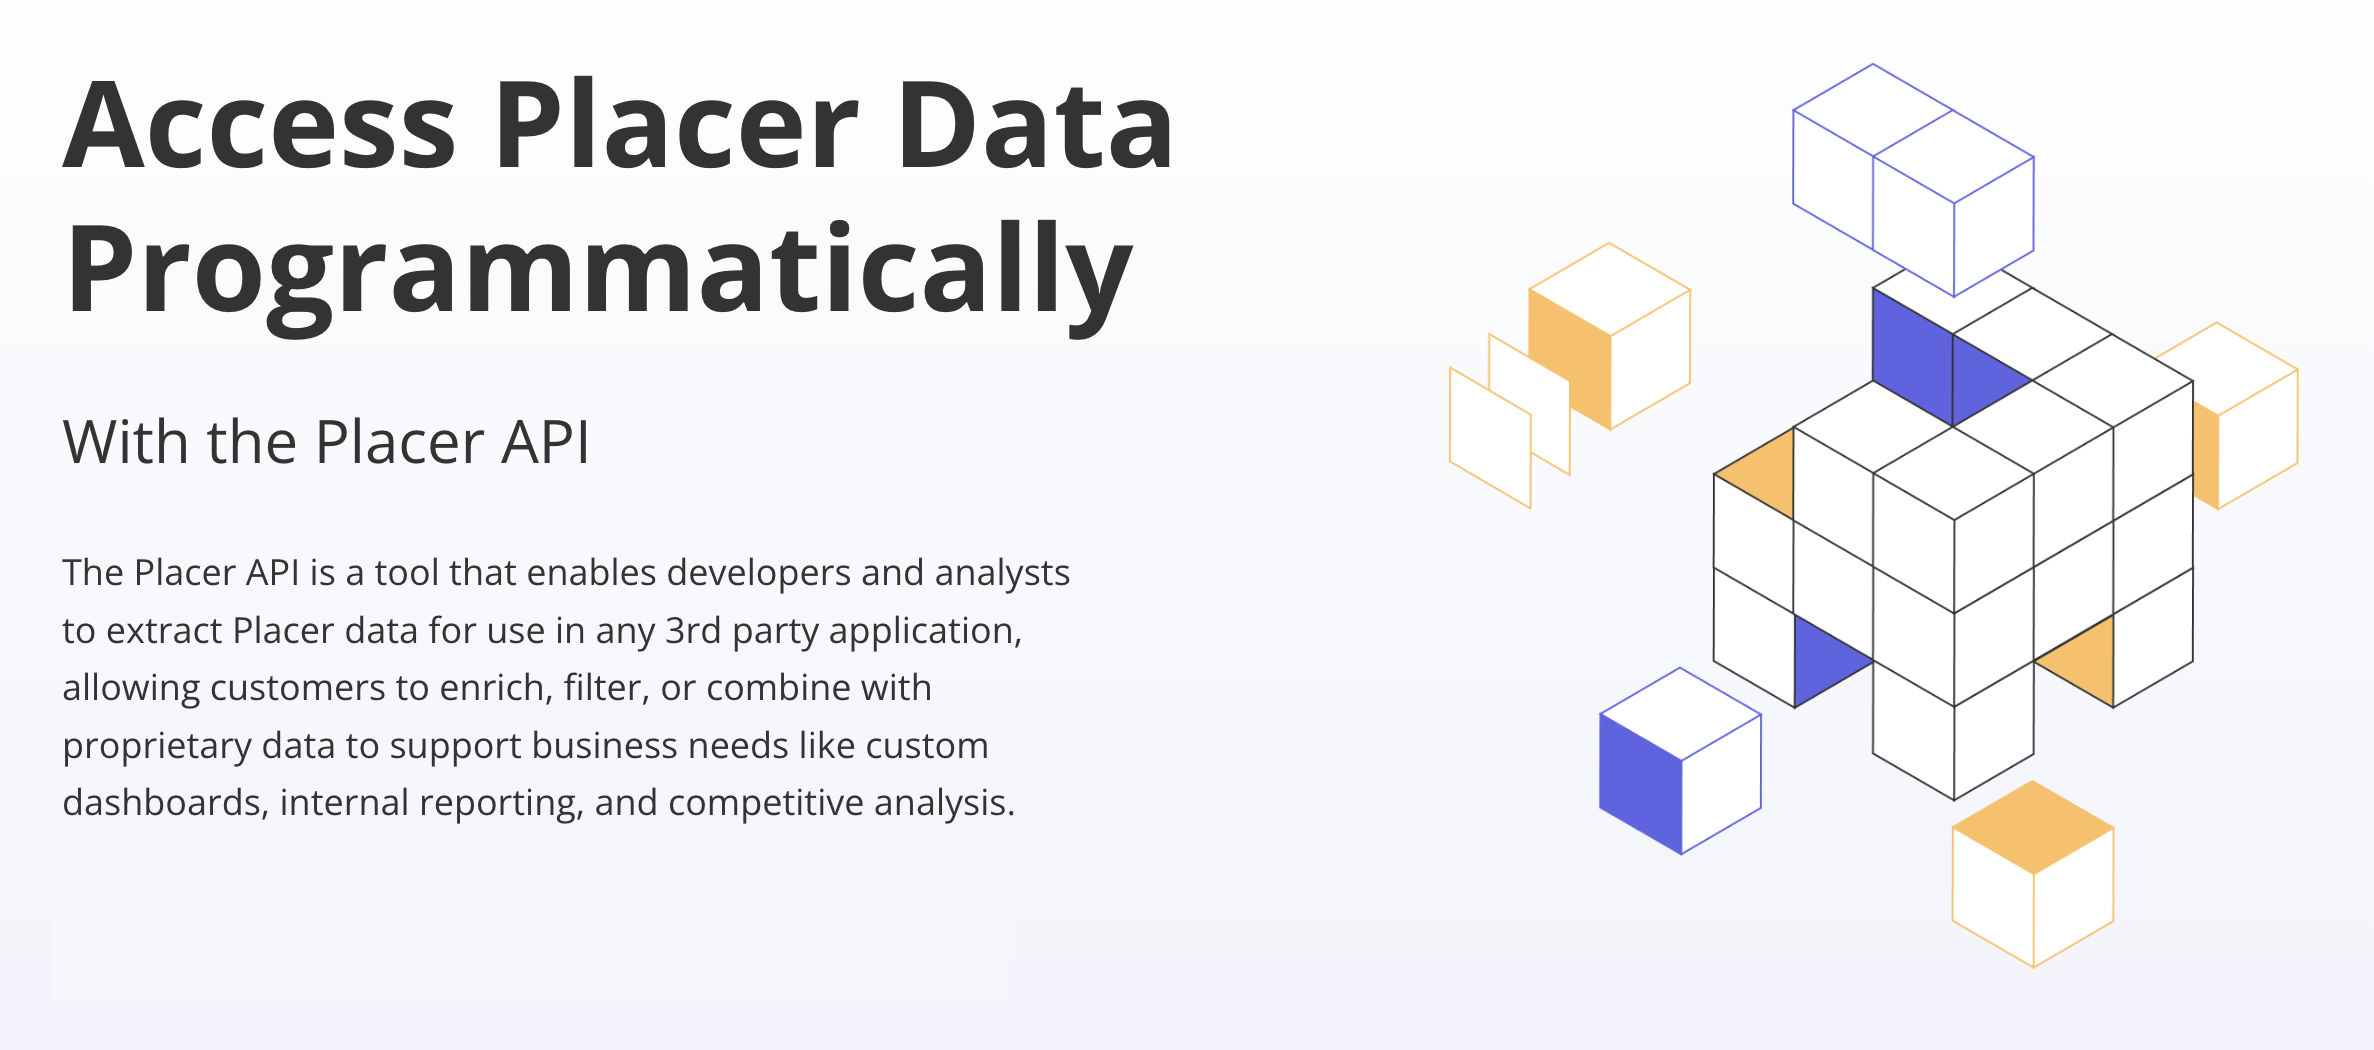

# Placer Documentation

Found [here](https://docs.placer.ai/reference/getting-started). 

## MAIN Dashboard Export-ish via API (Monthly Granularity)
The goal of this notebook is to pull data points for a chain or tag (comprised of venues or complexes) to approximate the dashboard export as best as possible. 

Other notebooks can deliver for the full-time frame desired. In this instance, the delivery will be upon the user-defined granularity.

The output of this code is a CSV file with:


*   One record per month for each entity (venue/complex)
*   Entity metadata for each record
*   Estimated visits/panel visits for each month
*   Hourly visits (optional)
*   Dwell time data (optional)
*   Trade area demographics (optional, update parameter for different datasets)
*   Rankings (optional, chain or category rankings)



### Enter Parameters
Fill in the following parameters in this first section:


*   Chain or Tag ID (chain:UNIQUE_STRING or tag:UNIQUE_STRING)
*   Start date 
*   End date


In [ ]:
# add a chain ID
chainId = 'complex:edf97e9b910dbcb7fc2ef2f7'

# add a start date and end date
# start date (first day of a month, YYYY-MM-DD format)
startDate = '2019-01-01'

# end date (first day of a month, one day after the last day of data that you'd like to pull YYYY-MM-DD format)
endDate = '2022-05-29'

### Required sections
Bring in python libraries



In [ ]:
# import these python modules
import requests
import time
import calendar
import json
import pandas as pd
from functools import reduce

from requests.adapters import HTTPAdapter


apiKey = "your_api_key_here"


### Mount your google drive for output purposes

In [ ]:
# export data to CSV
from google.colab import drive
drive.mount('/gdrive')


Execute each block of code from here until the "Optional datasets" comment below. Run these sections every time!

**Retry Function**

By default, retry calls your function endlessly until it returns rather than raising an error. We are limiting our retry to 15 seconds. 

**Response Codes**

The **200** reponse codes the retry function are generally good. 

Any **400** reponse codes likely due a bad request (possibly a store hasn't been opened and their is no data to return during that timeframe) or an account or permission issues and will not return the information. Any account or permission issues should be directed to the Customer Success Manager.

Any **500** response codes are Placer internal errors - likely a platform crash - reach out to Customer Success or Support.

More on response codes found in the documentation [here](https://docs.placer.ai/reference/get_v1-poi).

In [ ]:
# retry function
class RetryHTTPAdapter(HTTPAdapter):

  SECONDS_BETWEEN_RETRIES = 15

  def __init__(self, retry_time=75, *args, **kwargs):
    self.retry_time = retry_time
    super(RetryHTTPAdapter, self).__init__(*args, **kwargs)

  def send(self, *args, **kwargs):
    for _ in range(int(self.retry_time / self.SECONDS_BETWEEN_RETRIES)):
      response = super(RetryHTTPAdapter, self).send(*args, **kwargs)
      print(response.status_code)
      if response.status_code in [200, 204, 400, 401, 403, 404, 500]:
        break
      time.sleep(self.SECONDS_BETWEEN_RETRIES)
    return response

In [ ]:
def new_session():
  s = requests.Session()
  s.mount('https://', RetryHTTPAdapter(retry_time=75))
  return s

In [ ]:
# function to gather Placer IDs for a brand
def pull_placer_ids_by_chain(chainId):

  entities_endpt = 'https://papi.placer.ai/v1/poi/'+ chainId +'/entities'

  headers = {
      "Accept": "application/json",
      "x-api-key": apiKey
  }

  response = requests.request("GET", entities_endpt, headers=headers)

  print(response.status_code)

  if response.status_code == 200:
    json_data = json.loads(response.text)
  else:
    json_data = ''

  return json_data

In [ ]:
# function to gather entity info
def pull_entity_info(apiId):
  
  ent_info_endpt = 'https://papi.placer.ai/v1/poi/'+ apiId
  
  headers = {
      "Accept": "application/json",
      "x-api-key": apiKey
  }
  
  response = requests.request("GET", ent_info_endpt, headers=headers)

  print(response.status_code)

  if response.status_code == 200:
    json_data = json.loads(response.text)
  else:
    json_data = ''
  
  return json_data

In [ ]:
# function to pull visit trends
def pull_visit_trends(ids, startDate, endDate, granularity, s):
  
  vt_endpt = "https://papi.placer.ai/v1/reports/visit-trends"
  
  payload = {
      "apiIds": ids,
      "startDate": startDate,
      "endDate": endDate,
      "granularity": granularity
  }
  
  headers = {
      "Accept": "application/json",
      "Content-Type": "application/json",
      "x-api-key": apiKey
  }
                  
  response = s.post(vt_endpt, json=payload, headers=headers)

  if response.status_code == 200 or response.status_code == 207:
    json_data = json.loads(response.text)
  else:
    json_data = ''

  return json_data    

In [ ]:
# function to pull hourly visits
def pull_hourly_visits(id, startDate, endDate, s):
  
  hv_endpt = "https://papi.placer.ai/v1/reports/visit-metrics/hours"
  
  payload = {
      "apiId": id,
      "startDate": startDate,
      "endDate": endDate,
  }
  
  headers = {
      "Accept": "application/json",
      "Content-Type": "application/json",
      "x-api-key": apiKey
  }
                  
  response = s.post(hv_endpt, json=payload, headers=headers)

  if response.status_code == 200:
    json_data = json.loads(response.text)
  else:
    json_data = ''

  return json_data    

In [ ]:
# function to pull dwell time
def pull_dwell_time(id, startDate, endDate, s):
  
  dt_endpt = "https://papi.placer.ai/v1/reports/visit-metrics/dwell-time"
  
  payload = {
      "apiId": id,
      "startDate": startDate,
      "endDate": endDate,
  }
  
  headers = {
      "Accept": "application/json",
      "Content-Type": "application/json",
      "x-api-key": apiKey
  }
                  
  response = s.post(dt_endpt, json=payload, headers=headers)

  if response.status_code == 200:
    json_data = json.loads(response.text)
  else:
    json_data = ''

  return json_data    

In [ ]:
# function to pull TA demos
def pull_ta_demos(id, startDate, endDate, dataset, template, s):
  
  ta_endpt = "https://papi.placer.ai/v1/reports/trade-area-demographics"
  
  payload = {
      "apiId": id,
      "startDate": startDate,
      "endDate": endDate,
      "method": "tta",
      "benchmarkScope": "nationwide",
      "allocationType": "weightedCentroid",
      "trafficVolPct": 70,
      "withinRadius": 50,
      "dataset": dataset,
      "template": template,
  }
  
  headers = {
      "Accept": "application/json",
      "Content-Type": "application/json",
      "x-api-key": apiKey
  }
                  
  response = s.post(ta_endpt, json=payload, headers=headers)

  if response.status_code == 200:
    json_data = json.loads(response.text)
  else:
    json_data = ''

  return json_data  

In [ ]:
# function to pull rankings
def pull_rankings(id, startDate, endDate, scope, s):
  
  rank_endpt = "https://papi.placer.ai/v1/reports/ranking-overview"
  
  payload = {
      "apiId": id,
      "startDate": startDate,
      "endDate": endDate,
      "metric": "visits",
      "scope": scope,
      "distanceMiles": 15,
  }
  
  headers = {
      "Accept": "application/json",
      "Content-Type": "application/json",
      "x-api-key": apiKey
  }
                  
  response = s.post(rank_endpt, json=payload, headers=headers)

  if response.status_code == 200:
    json_data = json.loads(response.text)
  else:
    json_data = ''

  return json_data   

In [ ]:
# function to break ids into smaller chunks for visit trends endpoint
def divide_chunks(l, n):
  for i in range(0, len(l), n): 
    yield l[i:i + n]

In [ ]:
# function to calculate the last day of a month
def calc_last_date(sd):
  startDateSplit = sd.split('-')
  lastDay = calendar.monthrange(int(startDateSplit[0]), int(startDateSplit[1]))[1]
  lastDate = startDateSplit[0] + '-' + startDateSplit[1] + '-' + str(lastDay)
  return lastDate  

In [ ]:
# start session
session = new_session()

In [ ]:
# pull properties
properties = pull_placer_ids_by_chain(chainId)

200


In [ ]:
# form ids from json_response
ids = []
names = []
for venue in properties['data']: 
  if venue['flagged'] == False:
    ids.append(venue['apiId'])
    names.append(venue['name'])

In [ ]:
# create structure for output
ids_ser = pd.Series(data=ids, name='apiId')
names_ser = pd.Series(data=names, name='Name')
ids_names_df = ids_ser.to_frame()
ids_names_df = ids_names_df.merge(names_ser.to_frame(), left_index=True, right_index=True)

In [ ]:
# pull entity info for each id and merge to existing df
entity_info = []
for id in ids:
  data = pull_entity_info(id)
  entity_info.append(data)

200
200
403
200
200
200
403
200
403
200
403
403
403
403
403


In [ ]:
# extract data into series from entity info
ei_apiIds = []
ei_entityType = []
ei_lat = []
ei_lng = []
ei_formattedAddress = []
ei_city = []
ei_zipCode = []
ei_state = [] 
for entity in entity_info:
  if 'data' in entity:
    if 'apiId' in entity['data']:
      ei_apiIds.append(entity['data']['apiId'])
    else:
      ei_apiIds.append('')

    if 'entityType' in entity['data']:
      ei_entityType.append(entity['data']['entityType'])
    else:
      ei_entityType.append('')

    if 'geolocation' in entity['data']:
      ei_lat.append(entity['data']['geolocation']['lat'])
      ei_lng.append(entity['data']['geolocation']['lng'])
    else:
      ei_lat.append('')
      ei_lng.append('')

    if 'address' in entity['data']:
      ei_formattedAddress.append(entity['data']['address']['formattedAddress'])
      ei_city.append(entity['data']['address']['city'])
      ei_state.append(entity['data']['address']['state'])
      if 'zipCode' in entity['data']['address']:
        ei_zipCode.append(entity['data']['address']['zipCode'])
      else:
        ei_zipCode.append('')
    else:
      ei_formattedAddress.append('')
      ei_city.append('')
      ei_state.append('')

In [ ]:
# create dataframe from series and add to metadata df
ei_apiIds_ser = pd.Series(data=ei_apiIds, name='apiId')
ei_entityType_ser = pd.Series(data=ei_entityType, name='entityType')
ei_lat_ser = pd.Series(data=ei_lat, name='lat')
ei_lng_ser = pd.Series(data=ei_lng, name='lng')
ei_formattedAddress_ser = pd.Series(data=ei_formattedAddress, name='formattedAddress')
ei_city_ser = pd.Series(data=ei_city, name='city')
ei_zipCode_ser = pd.Series(data=ei_zipCode, name='zipCode')
ei_state_ser = pd.Series(data=ei_state, name='state')
data_frames = [ei_apiIds_ser.to_frame(), ei_entityType_ser.to_frame(), ei_lat_ser.to_frame(), ei_lng_ser.to_frame(), ei_formattedAddress_ser.to_frame(), ei_city_ser.to_frame(), ei_zipCode_ser.to_frame(), ei_state_ser.to_frame()]
metadata_df = reduce(lambda  left,right: pd.merge(left,right,left_index=True, right_index=True), data_frames)
metadata_df = ids_names_df.merge(metadata_df, on='apiId')

In [ ]:
# chunk IDs
n = 100
ids_chunked = list(divide_chunks(ids, n))

#### Visits Trends

More information can be found [here](https://docs.placer.ai/reference/post_v1-reports-visit-trends).

In [ ]:
# pull Visit Trends data
visitTrends = []
granularity = "month"
for id in ids_chunked:
  data = pull_visit_trends(id, startDate, endDate, granularity, session)
  for elm in data['data']:
    visitTrends.append(elm)

200


In [ ]:
metadata_dfs = []
for i, date in enumerate(visitTrends[0]['dates']):
  metadata_dfs.append(metadata_df.copy(deep=True))
  metadata_dfs[i]['startDate'] = date
  metadata_dfs[i]['granularity'] = granularity

In [ ]:
output_df = pd.concat(metadata_dfs, ignore_index=True)

In [ ]:
out = []
for i, v in enumerate(visitTrends):
  for j, d in enumerate(v['dates']):
    out.append(
      {
        'apiId': v['apiId'],
        'startDate': d,
        'visits': visitTrends[i]['visits'][j],
        'panelVisits': visitTrends[i]['panelVisits'][j]
      }
    )

visitTrends_df = pd.DataFrame(out)

In [ ]:
output_df = output_df.merge(visitTrends_df, how='left', on=['apiId', 'startDate'])

### Optional Datasets
Each section from here on is optional depending on your needs. For example, if you need hourly visits data, run the section below for hourly visits. 

Each endpoint call will cost credits per location

It is recommended to only run what is necessary for your needs at this time.

####**Hourly Visits**

More information can be found [here](https://docs.placer.ai/reference/post_v1-reports-visit-metrics-hours). 

In [ ]:
# # run this section for hourly visits data
# for i, row in output_df.iterrows():
#   #last day of the month
#   lastDate = calc_last_date(row['startDate'])
#   hv = pull_hourly_visits(row['apiId'],row['startDate'],lastDate, session)
#   if hv:
#     for idx, category in enumerate(hv['data']['bins']):
#       output_df.loc[output_df.index[i], 'hourly_' + str(category)] = hv['data']['estimatedFoottraffic'][idx]


####**Dwell Time**

More information can be found [here](https://docs.placer.ai/reference/post_v1-reports-visit-metrics-dwell-time).

In [ ]:
# # run this section for dwell time data
# for i, row in output_df.iterrows():
#   #last day of the month
#   lastDate = calc_last_date(row['startDate'])
#   dt = pull_dwell_time(row['apiId'],row['startDate'],lastDate, session)
#   if dt:
#     for idx, category in enumerate(dt['data']['bins']):
#       output_df.loc[output_df.index[i], 'dwell_time_' + str(category)] = dt['data']['estimatedFoottraffic'][idx]
#     output_df.loc[output_df.index[i], 'average_dwell_time'] = dt['data']['average']
#     output_df.loc[output_df.index[i], 'median_dwell_time'] = dt['data']['median']

202
200
202
204
202
200
202
200
202
200
202
200
202
200
202
200
202
204
202
200
202
200
202
200
202
200
202
204
202
200
202
204
202
200
202
200
202
200
202
200
202
204
202
200
202
204
202
200
202
200
202
200
202
200
202
204
202
200
202
204
202
200
202
200
202
200
202
200
202
204
202
200
202
204
202
200
202
200
202
200
202
200
202
204
202
200
202
204
202


#### Trade Area Options


*   `census2019` - `default`
*   `experian_mosaic` - `overview`, `households`, `population`
*   `spatial.ai` - `segments`, `segment_groupings`
*   `sti_popstats` - `default`, `5_years_forecast`, `10_years_forecast`
*   `sti_landscape` - `overview`, `households`, `population`
*   `sti_market_outlook` - `by_businesses`, `by_product_line`
*   `sti_workplace` - `default`, `demographics`
*   `sti_spending_patterns` - `default`, `food`, `transportation`, `healthcare`,`housing`, `entertainment`, `alcoholic_beverages`, `personal_care`


More information can be found in documentation [here](https://docs.placer.ai/reference/post_v1-reports-trade-area-demographics).

In [ ]:
# run this section for trade area demographics data
for i, row in output_df.iterrows():
  #last day of the month
  lastDate = calc_last_date(row['startDate'])
  ta = pull_ta_demos(row['apiId'],row['startDate'],lastDate, "sti_spending_patterns", "default", session)
  if ta:
    for group in ta['data']:
      for category in ta['data'][group]:
        if 'value' in ta['data'][group][category]:
          output_df.loc[output_df.index[i], str(group) + '_' + str(category) + '_value'] = ta['data'][group][category]['value']
        if 'percentage' in ta['data'][group][category]:
          output_df.loc[output_df.index[i], str(group) + '_' + str(category) + '_percentage'] = ta['data'][group][category]['percentage']
        if 'variableIndex' in ta['data'][group][category]:
          output_df.loc[output_df.index[i], str(group) + '_' + str(category) + '_variableIndex'] = ta['data'][group][category]['variableIndex']
        if 'variablePercentile' in ta['data'][group][category]:
          output_df.loc[output_df.index[i], str(group) + '_' + str(category) + '_variablePercentile'] = ta['data'][group][category]['variablePercentile']

####**Ranking**

More information on the ranking endpoint [here](https://docs.placer.ai/reference/post_v1-reports-ranking-index-top-ranking).

In [ ]:
# run this section for rankings data
for i, row in output_df.iterrows():
  #last day of the month
  lastDate = calc_last_date(row['startDate'])
  r = pull_rankings(row['apiId'],row['startDate'],lastDate, "chain", session)
  if r:
    for category in r['data'][0]['ranking']:
      if 'rank' in r['data'][0]['ranking'][category]:
        output_df.loc[output_df.index[i], str(category) + '_rank'] = r['data'][0]['ranking'][category]['rank']
      if 'percentile' in r['data'][0]['ranking'][category]:
        output_df.loc[output_df.index[i], str(category) + '_percentile'] = r['data'][0]['ranking'][category]['percentile']
      if 'rankedOutOf' in r['data'][0]['ranking'][category]:
        output_df.loc[output_df.index[i], str(category) + '_rankedOutOf'] = r['data'][0]['ranking'][category]['rankedOutOf']
      if 'radiusMiles' in r['data'][0]['ranking'][category]:
        output_df.loc[output_df.index[i], str(category) + '_radiusMiles'] = r['data'][0]['ranking'][category]['radiusMiles']
      if 'regionCode' in r['data'][0]['ranking'][category]:
        output_df.loc[output_df.index[i], str(category) + '_regionCode'] = r['data'][0]['ranking'][category]['regionCode']



# Export dataset

In [ ]:
output_df.to_csv('/gdrive/Shareddrives/SE Team - Shared Drive/Dashboard Export-ish via API/output/monthly_granularity_dashboard_export_ish_'+chainId+'_start_date_'+startDate+'_end_date_'+endDate+'.csv')